##Using a Simple RNN for forecasting
In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

build a stacked RNN using simpleRNN layers
use Lambda layers to reshape the input and scale the output
use the Huber loss during training
use batched data windows to generate model predictions
You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##Utilities

In [41]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

##Sythetic Data Utilities 

In [7]:
def trend(time, slope=0):
  """
  Generate synthetic data that follows a straight line given a slope value

  Args:
    time (array of int) - contains the time steps
    slope (float) - determines the direction and steepness of the line

  Returns: 
    series (array of float) - measurements that follow a straight line
  """

  #Compute the linear given the slope 
  series = slope * time 

  return series 


def seasonal_pattern(season_time):
  """
  Just an arbitrary pattern that can be changed 

  Args:
    season_time (array of float) - contains the measurements per time step

  Returns:
    data_pattern (array of float) - contains revised measurement values according to the defined pattern
  """

  #Generates the values using arbitrary pattern 
  data_pattern = np.where(season_time < 0.4,
                          np.cos(season_time * 2 * np.pi),
                          1 / np.exp(3 * season_time))
  
  return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
  """
  Repeats the same pattern at each period 

  Args:
    time (array of int) - contains the time steps 
    period (int) - number of time steps before the pattern repeats 
    amplitude (int) - number of time stps to shift the measured values 

  Returns:
    data_pattern (array of float) - seasonal data scaled by the defined amplitude
  """

  # Define the measured values per period 
  season_time = ((time + phase) % period) / period 

  # Generates the seasonal data scaled by the defined amplitude 
  data_pattern = amplitude * seasonal_pattern(season_time)

  return data_pattern


def noise(time, noise_level=1, seed=None):
  """
  Generates a normally distributed noisy signal 

  Args:
    time(array of int) - contains the time steps 
    noise_level (float) - scaling factor for the generated signal 
    seed (int) - number generator seed for repeatability 
  """

  #Intitialize the random number generator 
  rnd = np.random.RandomState(seed)

  #Generate a random number for each time step and scale by the noise level
  noise = rnd.randn(len(time)) * noise_level

  return noise

##Generate the synthetic data

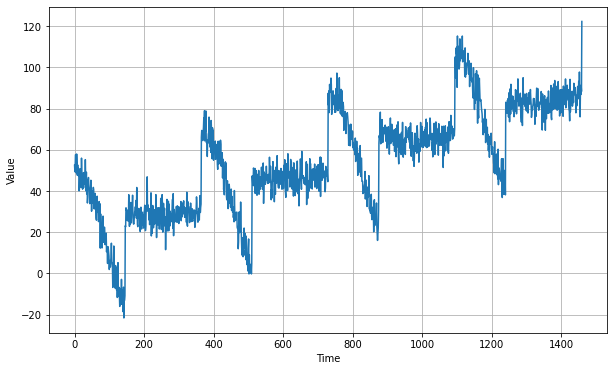

In [10]:
#Parameters 
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

#Create the series 
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

#Update with noise
series += noise(time, noise_level, seed=42)

#Plot the result 
plot_series(time, series)

##Split the dataset 

In [11]:
from numpy.lib.shape_base import split
##Define the split time
split_time = 1000

#Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

#Get the validation set 
time_valid = time[split_time:]
x_valid = time[split_time:]

##Prep Features and Labels 

In [12]:
#Parameters 
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [20]:
#Generate the dataset windows 
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [24]:
#Print shapes of features and label 
for window in dataset.take(1):
  print(f'Shape of feature: {window[0].shape}')
  print(f'Shape of label: {window[1].shape}')



Shape of feature: (32, 20)
Shape of label: (32,)


##Build the model 

* The model is composed mainly of `SimpleRNN` layers. This type of RNN simply routs its output back to the input. Stack two of these layers in the model. This first should contain `return_sequences` set to `True`

* `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature]`. So reshape the window from `(32, 20)` to `(32, 20, 1)`.noise_level

* This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. The reshaping can be done in a seperate code block but can also be accomplished using `Lambda layers`

* Instead of using a `Dense` layer output as done in previous labs, scale up the output to around the same figures in the label. This will help the training. 

* It's dependent on activation functions that's used in the model. `SimpleRNN` uses `tanh` by default and that has an output range of [-1, 1]. Use another  `Lambda()` layer to sclae the ouput by 100 before it adjusts the layer weights

In [25]:
#Build the model 
model_tune = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                             input_shape = [window_size]),
      tf.keras.layers.SimpleRNN(40, return_sequences=True),
      tf.keras.layers.SimpleRNN(40),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100)
])

#Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


##Tune the learning rate
Define a learning rate schedule that changes the hyperparameter dynamically

Use the `Huber Loss` function to minimize sensitivity to outliers

In [26]:
#Set the learning rate scheduler 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

#Intialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

#Set the training parameters 
model_tune.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

#Train the model 
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 5s 22ms/step - loss: 51.2894 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 42.4190 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 33.9964 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 26.8978 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 20.9819 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 16.4468 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 13.6838 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 24ms/step - loss: 12.4125 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 21ms/step - loss: 11.9132 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 22ms/step - loss: 11.6272 - lr: 2.8184e-08
Epoch 11/

Visualize the results and pick the optimal learning rate

(1e-08, 0.001, 0.0, 50.0)

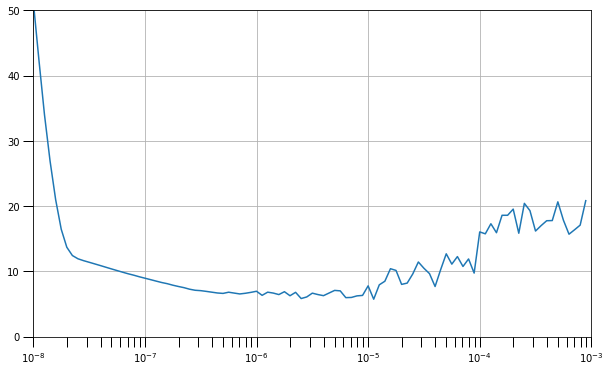

In [27]:
#Define the learning rate array 
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

#Set the figure size 
plt.figure(figsize = (10,6))

#Set the grid
plt.grid(True)

#Plot the loss in log scale
plt.semilogx(lrs, history.history['loss'])

#Increase the tickmarks size
plt.tick_params('both', length = 10, width = 1, which = 'both')

#Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

Change the boundaries of the graph to zoom in 

(1e-06, 1e-05, 0.0, 10.0)

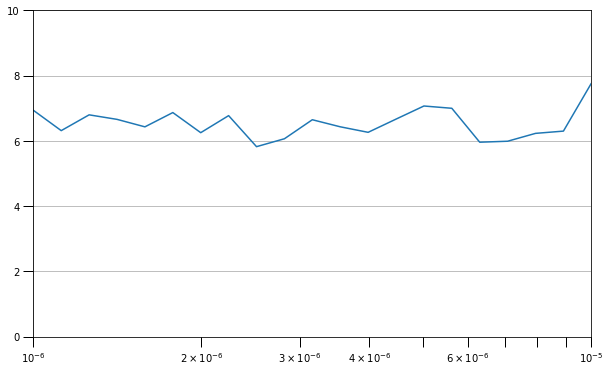

In [30]:
#Set the figure size 
plt.figure(figsize=(10,6))

#Set the grid
plt.grid(True)

#Plot the loss in log scale
plt.semilogx(lrs, history.history['loss'])

#Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

#Set the plot boundaries
plt.axis([1e-6, 1e-5, 0, 10])

##Train the model 
Train the model again but change the learning rate to lowest point on graph to optimize the model 

In [ ]:
#Set the learning rate
learning_rate = 2.5 * 1e-6

#Build the model 
model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                             input_shape = [window_size]),
      tf.keras.layers.SimpleRNN(40, return_sequences=True),
      tf.keras.layers.SimpleRNN(40),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
])

#set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

#Set the training parameters 
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

#Train the model
history = model.fit(dataset, epochs=100)

##Model pediction

Generate the model predicitons for the validation set time_range. The model is a lot larger than before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow 

In [38]:
#Initialize a list 
forecast = []

#Reduce the original series 
forecast_series = series[split_time - window_size:]

#Use the model to predict datapoints per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

#Convert to a numpy array and drop single dimensional axes 
results = np.array(forecast).squeeze()

print(x_valid.shape)
print(results.shape)


(461,)
(461,)


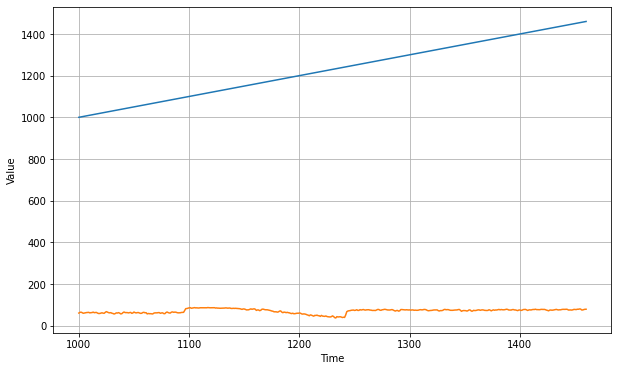

In [42]:
#Plot the results
plot_series(time_valid, (x_valid, results))

Optimize the prediction by leveraging TensorFlow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, pass in an entire batch of windows and let the model process it in parallel. 

The function below accomplishes that and almost mirrors the `windowed_dataset` function but it doesn't shuffle the windows. That's because the outpu should be in its proper sequence so that it cna be properly compared to the validation set

In [43]:
def model_forecast(model, series, window_size, batch_size):
  """
  Uses an input model to generate predictions on data windows 

  Args:
    model (TF Keras Model) - model that accepts data windows
    series (array of float) - contains the values of the time series 
    window_size (int) - the number of time steps to include in the window 
    batch__size (int) - size of the batches that will run through the prediciton
  
  Returns:
    forecast (numpy array) - array containing predictions
  """

  #Generate a TF Dataset from the series value
  dataset = tf.data.Dataset.from_tensor_slices(series)

  #Window the data but only take those with specified size
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)

  #Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda w: w.batch(window_size))

  #Create batches of windows 
  dataset = dataset.batch(batch_size).prefetch(1)

  #Get the predictions on the entire dataset
  forecast = model.predict(dataset)

  return forecast

Run the predictions using the `model_forecast` function

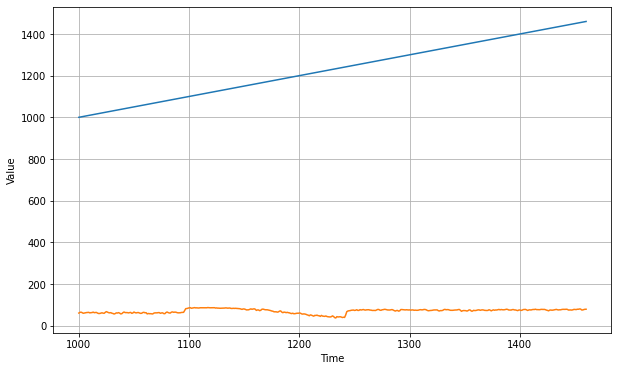

In [44]:
#Reduce the original series 
forecast_series = series[split_time - window_size: -1]

#Use helper function ot generate predictions 
forecast = model_forecast(model, forecast_series, window_size, batch_size)

#Drop single dimensional axis
results = forecast.squeeze()

#Plot the results
plot_series(time_valid, (x_valid, results))

Compute the MSE and MAE to visualize the performance of the model 

In [45]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1361965.1
1159.7744
